<a href="https://colab.research.google.com/github/SezanMert/NMA_Project/blob/main/Copy_of_NMA_frequency_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install mne_connectivity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.6 MB/s 
     |████████████████████████████████| 7.5 MB 8.9 MB/s 


In [2]:
# import packages

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os, requests
import torch

from sklearn.decomposition import PCA
# import torch

import mne_connectivity as mnec

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# data retrieval

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)
                
alldat = np.load(fname, allow_pickle=True)['dat']

In [4]:
def get_subject_data(subject = 0, im_vs_real = 0, vector = True):
    """
    Get brain activity data from subject performing imagery or real movement
    
    Args:
    - subject: number of subject (0-6)
    - im_vs_real: 0 real, 1 imaginary
    
    Returns:
    - samples: 2-dim. numpy array (trials for each channel x time) 
        with voltage time series in uV
    - labels: 2-dim. numpy array (trials for each channel x 2) 
        with number of brodman area and movement type for each sample
    """
    
    data = alldat[subject][im_vs_real]
    
    trange = np.arange(0, 3000)
    V = data['V'].astype('float32')
    scale_uv = data['scale_uv'].astype('float32')

    number_of_trials = 60 # len(data['t_on']) = 60 for all cases
    number_of_channels = len(data['locs'])

    trial_indices = (data['t_on'][:, np.newaxis] + trange).flatten() 
    
    labels = np.zeros((number_of_trials, number_of_channels, 2)) # trials for each electrode location x 2, 
                                                                 # with brodmann area & movement type as columns
    samples = np.zeros((number_of_trials, number_of_channels, 3000)) # trials for each electrode location x time

    movement_types = data['stim_id']
    labels[:,:,1] = np.tile(movement_types, (number_of_channels, 1)).T

    # iterate through all channels with this loop
    for ch_num in range(number_of_channels):

        number_of_brodmann_area = int(data['Brodmann_Area'][ch_num][14:])
        labels[:, ch_num,  0] = np.full(number_of_trials, number_of_brodmann_area)
        
        V_in_uv = V[:, ch_num] * scale_uv[ch_num]
        samples[:, ch_num, :] = V_in_uv[trial_indices].reshape((number_of_trials, 3000))

    # choose time series vectors for PCA
    if vector == True:
        labels = labels.reshape((number_of_trials * number_of_channels, 2))
        samples = samples.reshape((number_of_trials * number_of_channels, 3000))
    
    return(samples, labels)

def correlate_matrices(corr1, corr2):
    """Correlate off-diagonal elements of two 2-dim matrices

    Args:
        corr1 (np.ndarray): S x S correlation coefficient matrix
        corr2 (np.ndarray): S x S correlation coefficient matrix to correlate with corr1

    Returns:
        float: correlation coefficient between the off-diagonal elements
              of corr1 and corr2

    """

    # Extract off-diagonal elements of each RDM
    ioffdiag = np.tril_indices(corr1.shape[0], k=1)  # indices of off-diagonal elements
    corr1_offdiag = corr1[ioffdiag]
    corr2_offdiag = corr2[ioffdiag]

    # compute correlation coefficient 
    corr_coef = np.corrcoef(corr1_offdiag, corr2_offdiag)[0,1]

    return corr_coef

def diff_measure(corr_coeff):
    # compute a measure of dissimilarity from correlation 
    return((1 - corr_coeff) / 2)

In [5]:
def cross_coherence(freq_band = [30, 100], random = False, corr_degree = 0):
    """...
    
    args:
      
    """

    corrs = [] 
    coh_mat_re = []
    coh_mat_im = []
    # diffs_stds = [] # for error propagation
    
    for subject in range(7):
        
        if random == False: 
            X_re, y_re = get_subject_data(subject, im_vs_real = 0, vector = False)
            X_im, y_im = get_subject_data(subject, im_vs_real = 1, vector = False)
        else:
            X_re, X_im = get_random_data(corr_degree)
        

        coh_re = mnec.spectral_connectivity_epochs(X_re, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)
        coh_im = mnec.spectral_connectivity_epochs(X_im, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)

        number_of_channels = X_re.shape[1]
        coh_mat_re.append(coh_re.get_data().reshape((number_of_channels, number_of_channels)))
        coh_mat_im.append(coh_im.get_data().reshape((number_of_channels, number_of_channels)))

        #corr = correlate_matrices(coh_mat_re, coh_mat_im)
       
        #corrs.append(corr)
        
    return(coh_mat_re, coh_mat_im)

In [6]:
coh_re, coh_im = cross_coherence()


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1035 connections
    using t=0.000s..2.999s for estimation (3000 points)
    frequencies: 30.0Hz..100.0Hz (211 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing conne

In [7]:
print(len(coh_re))
print(coh_re[0].shape)
print(coh_re[1].shape)

7
(46, 46)
(64, 64)


Text(0.5, 1.0, 'Electrode Coherence values of Gamma Band of Subject 0 - Real Movement')

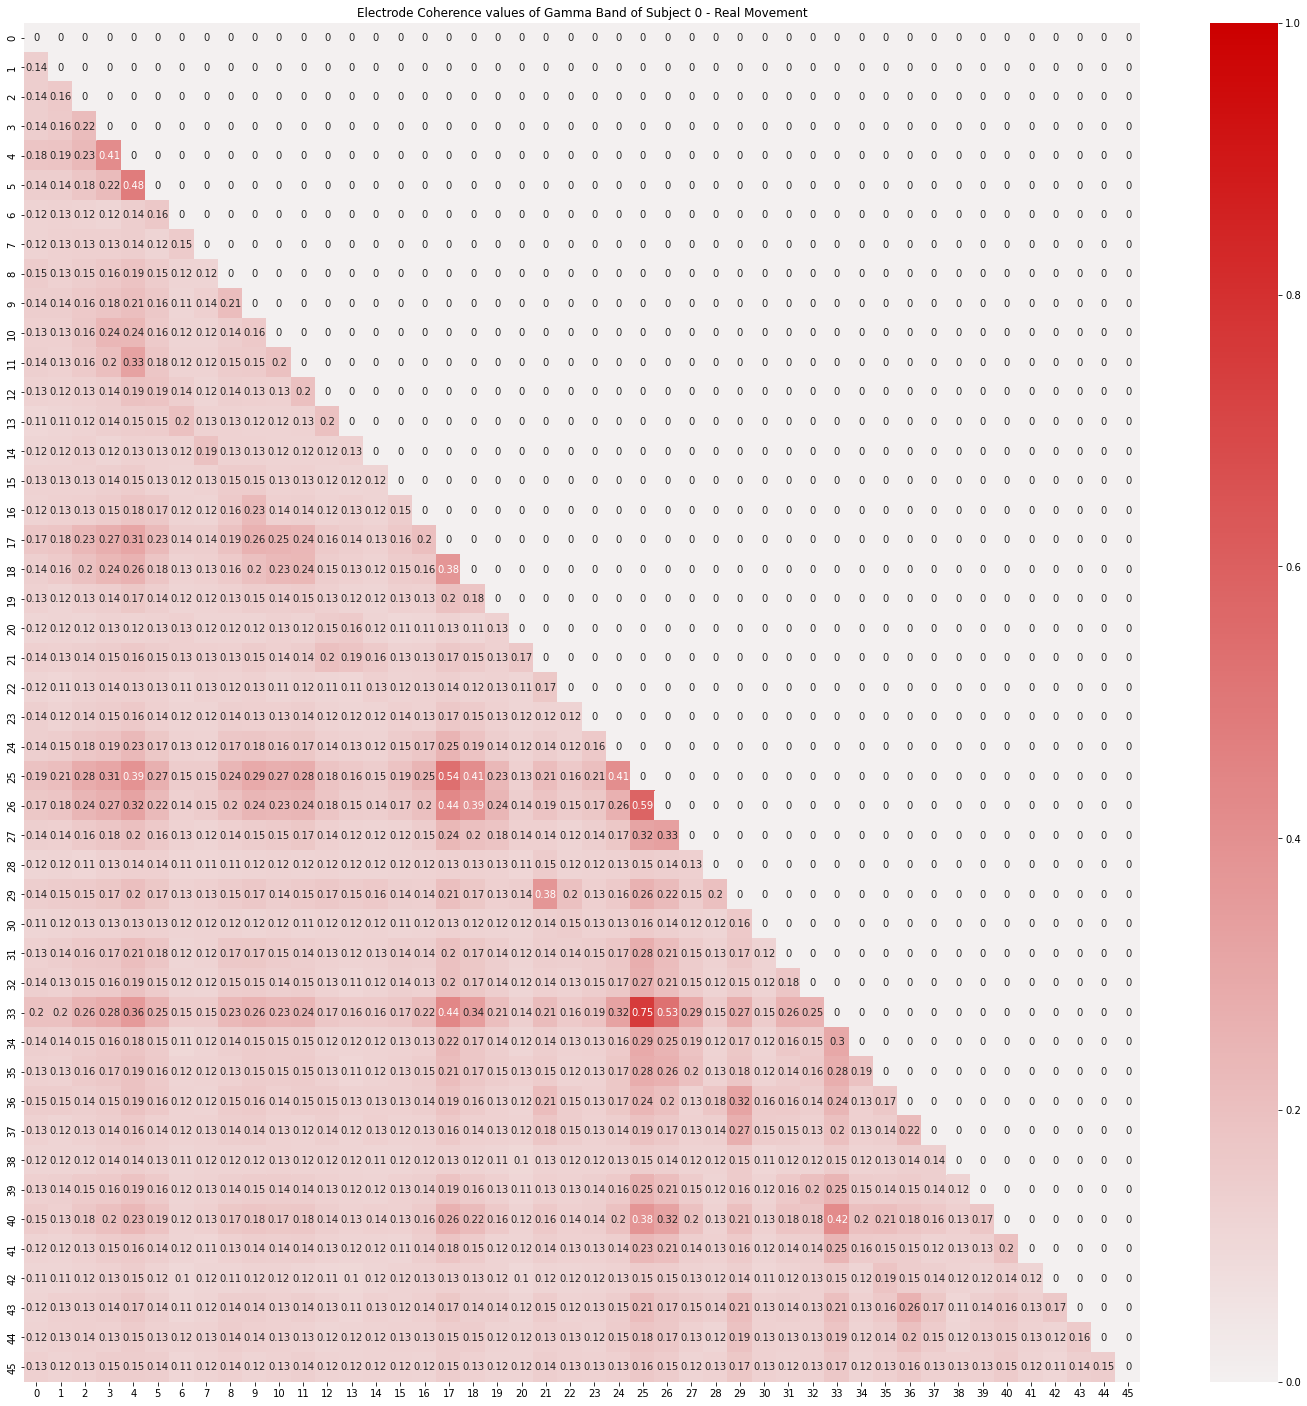

In [38]:
import seaborn as sns
import matplotlib.pylab as plt

plt.figure(figsize=(25, 25))
colormap = sns.color_palette("light:#CC0000", as_cmap=True)
hm = sns.heatmap(coh_re[0], vmin=0.0, vmax=1.0,annot=True, cmap=colormap)
plt.title("Electrode Coherence values of Gamma Band of Subject 0 - Real Movement")


In [19]:
from itertools import combinations

def unique_pairwise_combinations(n):

  channels = list(range(n))

  combs = [",".join(map(str, comb)) for comb in combinations(channels, 2)]

  return combs


In [20]:
def cross_coh_for_BA(coh_mat_one_sub, num_BA, BA_ch_correspondence, BA_uniques, subject):

   BA_idx = unique_pairwise_combinations(num_BA)

   BA_mtx = np.zeros((num_BA, num_BA))

   for BA_pair in BA_idx:

     BA1 = BA_uniques[int(BA_pair.split(',')[0])] 
     BA2 = BA_uniques[int(BA_pair.split(',')[1])] 

     BA1_ch_idx = [index for (index, item) in enumerate(BA_ch_correspondence) if item == BA1]
     BA2_ch_idx = [index for (index, item) in enumerate(BA_ch_correspondence) if item == BA2]

     cohs_list = []

     for ch1 in BA1_ch_idx:
       for ch2 in BA2_ch_idx:

        new_ch1 = max(ch1,ch2)
        new_ch2 = min(ch1, ch2)
        cohs_list.append(coh_mat_one_sub[new_ch1, new_ch2])

     BA_mtx[int(BA_pair.split(',')[0]), int(BA_pair.split(',')[1])] = np.mean(np.array(cohs_list))

   return BA_mtx


In [42]:
def cross_coh_BA_all_patients(coh_mat_re, coh_mat_im):

  all_BA_coh_mtx = []
    
  for subject in range(7):

    X_re, y_re = get_subject_data(subject, im_vs_real = 0, vector = False)

    BA = []

    for ch_num in range(X_re.shape[1]):

      BA.append(int(y_re[0, ch_num, 0]))

    num_of_uniq_BA = len(set(BA))

    BA_uniqs = np.unique(np.array(BA))

    coh_mat_re_one_sub = coh_mat_re[subject]
    coh_mat_im_one_sub = coh_mat_im[subject]

    BA_for_one_subj_re = cross_coh_for_BA(coh_mat_re_one_sub, num_of_uniq_BA, BA, BA_uniqs, subject)
    BA_for_one_subj_im = cross_coh_for_BA(coh_mat_im_one_sub, num_of_uniq_BA, BA, BA_uniqs, subject)

    BA_dict = {'re': BA_for_one_subj_re, 'im': BA_for_one_subj_im, 'labels': BA_uniqs}

    all_BA_coh_mtx.append(BA_dict)

        
  return(all_BA_coh_mtx)


In [43]:
BA_cohs = cross_coh_BA_all_patients(coh_re, coh_im)

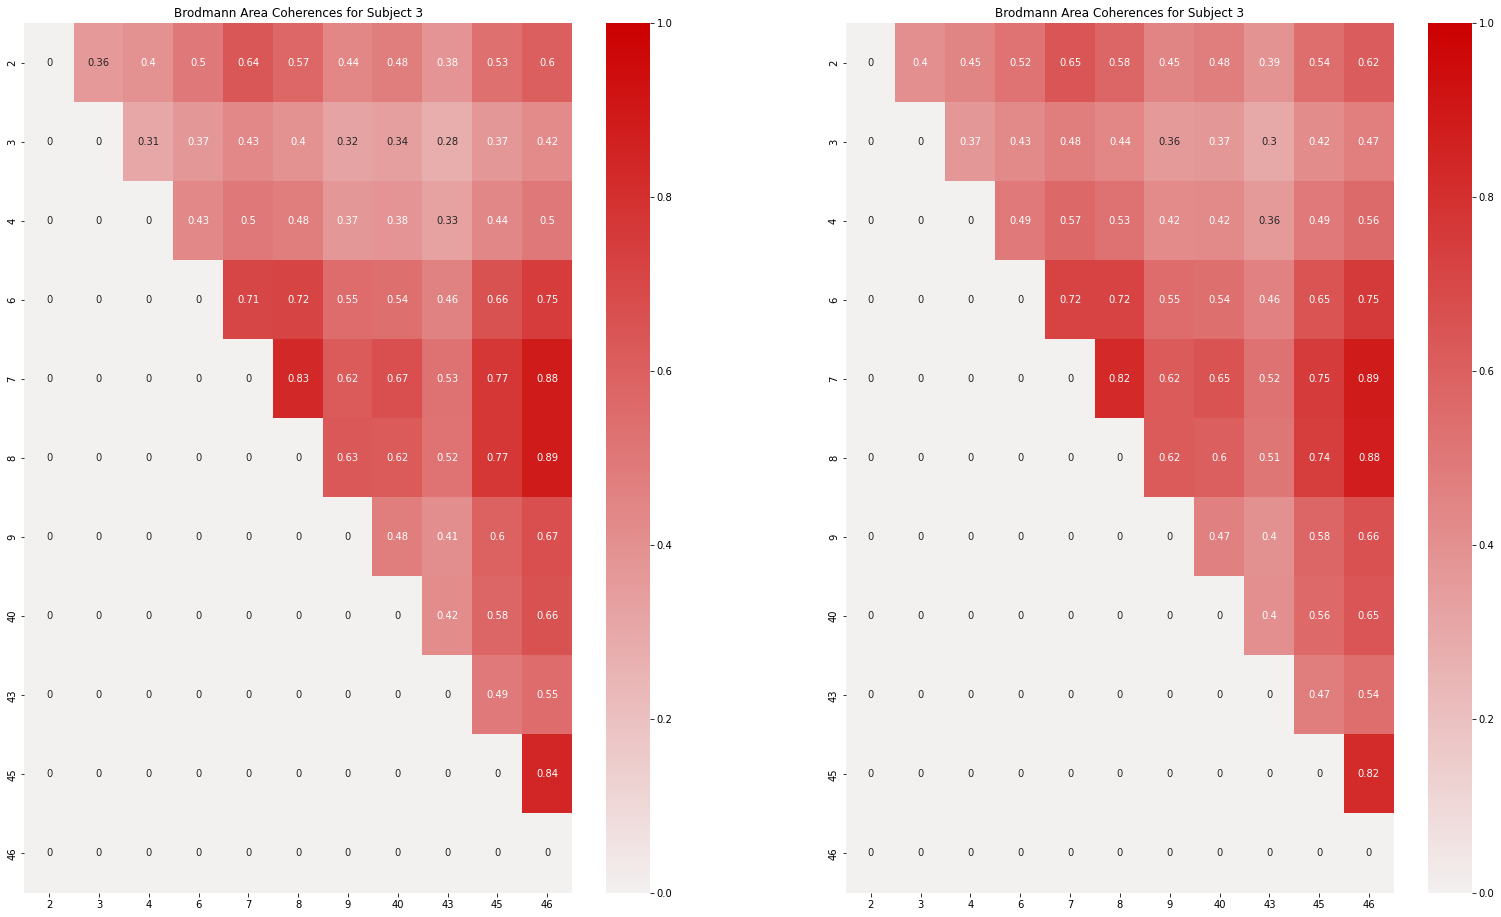

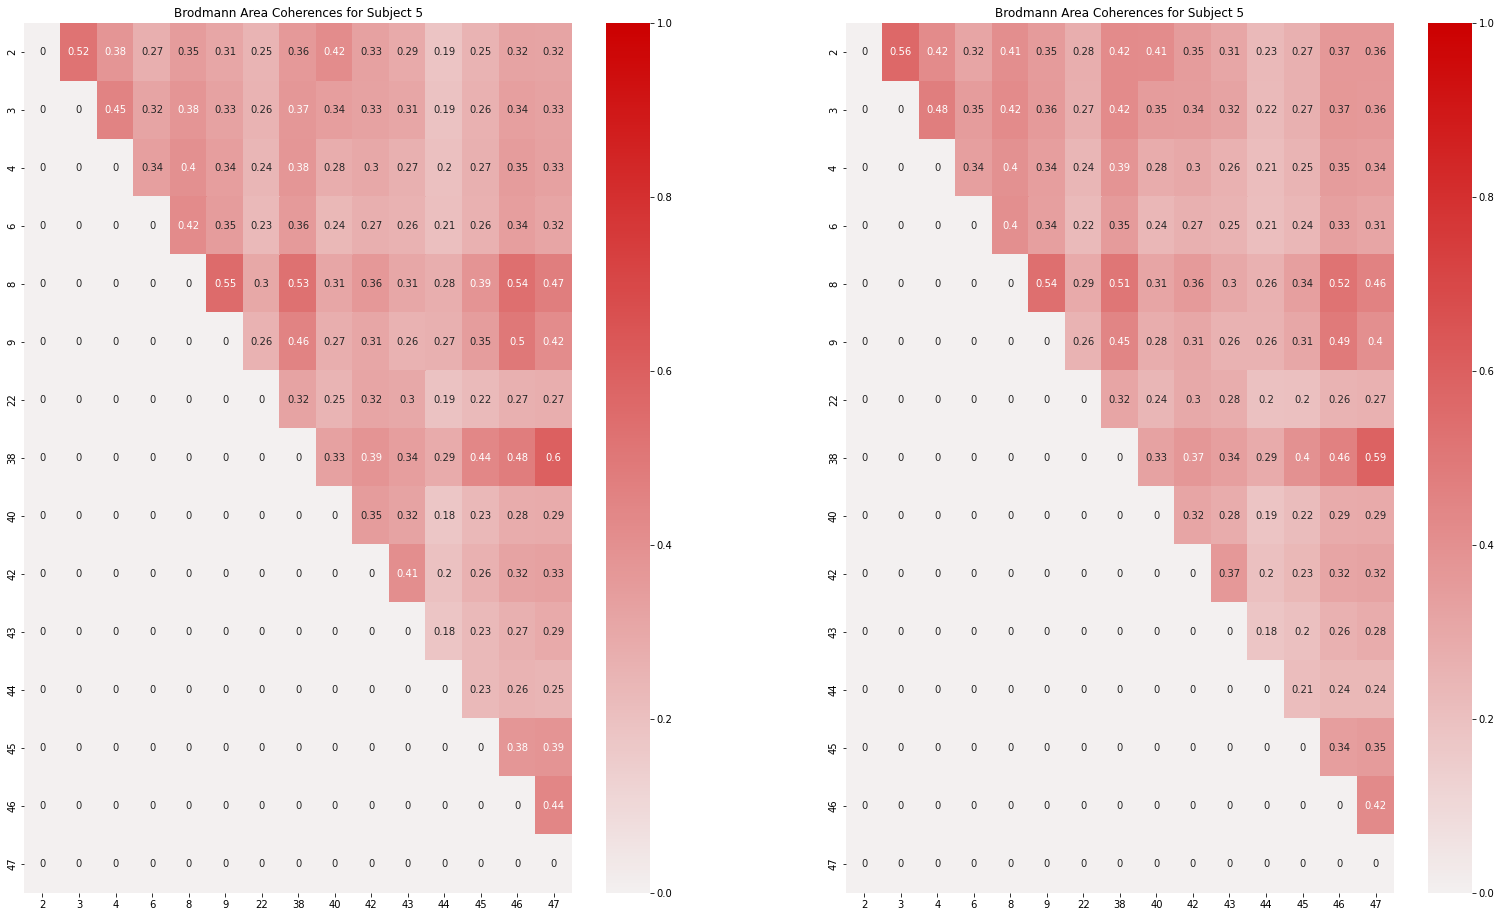

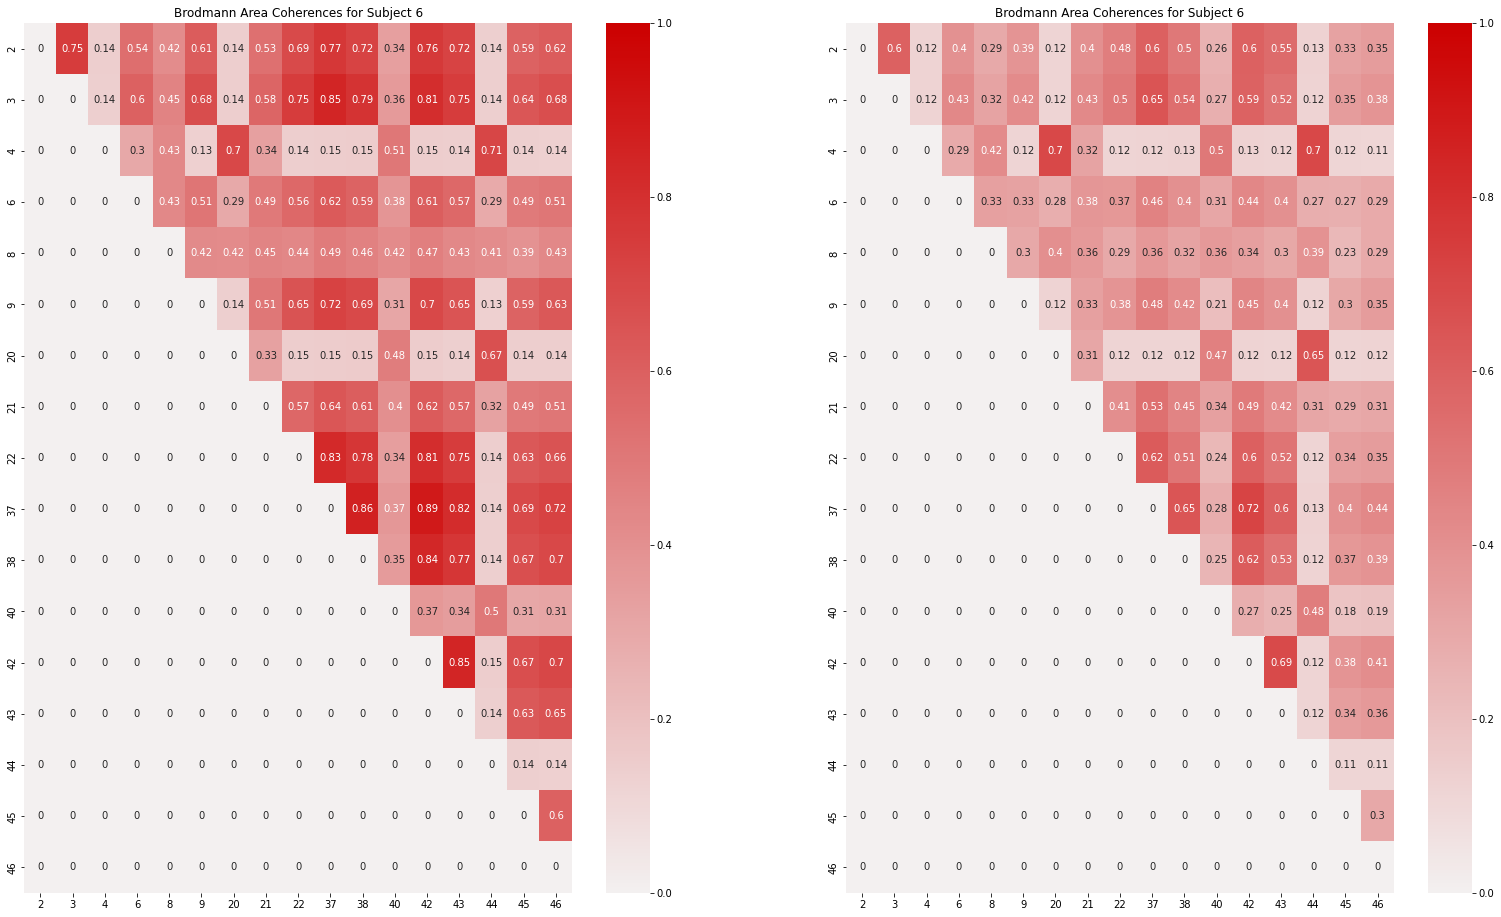

In [44]:
selected_subs = [3, 5, 6]

for sub in selected_subs:
  plt.figure(figsize=(27, 16))
  plt.subplot(1,2,1)
  colormap = sns.color_palette("light:#CC0000", as_cmap=True)
  hm = sns.heatmap(BA_cohs[sub]['re'], vmin=0.0, vmax=1.0, xticklabels = BA_cohs[sub]['labels'], yticklabels = BA_cohs[sub]['labels'], annot=True, cmap=colormap)
  plt.title(f"Brodmann Area Coherences for Subject {sub}")

  plt.subplot(1,2,2)
  colormap = sns.color_palette("light:#CC0000", as_cmap=True)
  hm = sns.heatmap(BA_cohs[sub]['im'], vmin=0.0, vmax=1.0, xticklabels = BA_cohs[sub]['labels'], yticklabels = BA_cohs[sub]['labels'], annot=True, cmap=colormap)
  plt.title(f"Brodmann Area Coherences for Subject {sub}")
